# Using Labels from Different Relation Types to Predict Gene Interacts Gene Sentences

This notebook is designed to predict the gene interacts gene (GiG) relation. The first step in this process is to label our train, dev, and test sentences (split = 3,4,5). We will label these sentences using all of our handcrafted label functions. The working hypothesis here is there are shared information between different relations, which in turn should aid in predicting the gene interacts gene relation. After the labeling process, the next step is to train a generative model that will estimate the likelihood of the positive class ($\hat{Y}$) given our annotated label matrix. **Note**: This process doesn't involve any sentence context, so the only information used here are categorical output.

## Set up the environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from collections import defaultdict
import os
import pickle
import sys

sys.path.append(os.path.abspath('../../../modules'))

# Bayesian Optimization
from hyperopt import fmin, hp, tpe, Trials

from itertools import chain
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.metrics import roc_curve, auc, f1_score, precision_recall_curve, accuracy_score
from tqdm import tqdm_notebook

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.learning.pytorch.rnn.rnn_base import mark_sentence
from snorkel.learning.pytorch.rnn.utils import candidate_to_tokens
from snorkel.models import Candidate, candidate_subclass

from metal.analysis import lf_summary
from metal.label_model import LabelModel
from metal.utils import plusminus_to_categorical

from gensim.models import FastText
from gensim.models import KeyedVectors

from utils.notebook_utils.label_matrix_helper import label_candidates, get_auc_significant_stats
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes, generate_results_df
from utils.notebook_utils.plot_helper import plot_curve, plot_label_matrix_heatmap
from utils.notebook_utils.train_model_helper import (
    train_baseline_model,
    run_random_additional_lfs
)

sys.path.append(os.path.abspath('data/label_functions'))
sys.path.append(os.path.abspath('../../../disease_gene/disease_associates_gene/single_task/data/label_functions'))
sys.path.append(os.path.abspath('../../../compound_disease/compound_treats_disease/single_task/data/label_functions'))
sys.path.append(os.path.abspath('../../../compound_gene/compound_binds_gene/single_task/data/label_functions'))

from gene_gene_lf import GG_LFS
from disease_gene_lfs import DG_LFS
from compound_disease_lf import CD_LFS
from compound_gene_lf import CG_LFS

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2903: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [4]:
GeneGene = candidate_subclass('GeneGene', ['Gene1', 'Gene2'])

In [5]:
quick_load = True

## Load the Data and Label the  Sentences

This block of code is designed to label the sentences using our label functions. All the sentences are located in our postgres database that is store locally on the lab machine. The labeling process is defined as follows: Given a candidate id, we use the sqlalchemy library to extract a candidate object. Using this object and we pass it through a series of label functions that will output a 1 (positive), -1 (negative) or 0 (abstain) depending on the rule set. Lastly we aggregate the output of these functions into a sparse matrix that the generative model will use. Since these steps are pretty linear, we parallelized this process using python's multithreading library. Despite the optimization, this process will take almost 20 hourse for about 2.8 million sentences.

In [6]:
total_candidates_df = pd.read_table("../dataset_statistics/data/all_gig_candidates.tsv.xz")
total_candidates_df.head(2)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,gene1_id,gene1_name,gene2_id,gene2_name,sources,n_sentences,hetionet,has_sentence,split,partition_rank,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,10321,CRISP3,II_literature|hetio-dag,5,1,1,3,0.436432,0.0,0.0,2,65570963,Human CRISP-3 binds serum alpha(1)B-glycoprote...,11,20992573
1,1,A1BG,10321,CRISP3,II_literature|hetio-dag,5,1,1,3,0.436432,0.0,0.0,3,65570968,BACKGROUND: CRISP-3 was previously shown to be...,21,20930188


In [7]:
spreadsheet_names = {
    #'train': 'data/sentences/sentence_labels_train.xlsx',
    'dev': 'data/sentences/sentence_labels_dev.xlsx',
    'test': 'data/sentences/sentence_labels_test.xlsx'
}

In [8]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key], "curated_gig")
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 500
Size of test set: 500


In [9]:
lfs = (
    list(GG_LFS["GiG"].values()) +
    list(DG_LFS["DaG"].values())[7:37] +
    list(CD_LFS["CtD"].values())[3:25] + 
    list(CG_LFS["CbG"].values())[9:29]  
    
)
lf_names = (
    list(GG_LFS["GiG"].keys()) +
    list(DG_LFS["DaG"].keys())[7:37] + 
    list(CD_LFS["CtD"].keys())[3:25] +
    list(CG_LFS["CbG"].keys())[9:29]  
)

In [10]:
if not quick_load:
    label_matricies = {
        'train':label_candidates(
            session, 
            (
                total_candidates_df
                .query("split==3&gene_mention_count==2")
                .candidate_id
                .values
                .tolist()
            ),
            lfs, 
            lf_names,
            num_threads=10,
            batch_size=50000,
            multitask=False
        )
    }

In [11]:
if not quick_load:
    label_matricies.update({
        key:label_candidates(
            session, 
            candidate_dfs[key]['candidate_id'].values.tolist(),
            lfs, 
            lf_names,
            num_threads=10,
            batch_size=50000,
            multitask=False
        )
        for key in candidate_dfs
    })

In [12]:
# Save the label matricies to a file for future loading/error analysis
if not quick_load:
    (
        label_matricies['train']
        .sort_values("candidate_id")
        .to_csv("data/train_sparse_matrix.tsv.xz", sep="\t", index=False)
    )
    (
        label_matricies['dev']
        .sort_values("candidate_id")
        .to_csv("data/dev_sparse_matrix.tsv.xz", sep="\t", index=False)
    )
    (
        label_matricies['test']
        .sort_values("candidate_id")
        .to_csv("data/test_sparse_matrix.tsv.xz", sep="\t", index=False)
    )
# Quick load the label matricies
else:
    label_destinations = {
        'train':"data/train_sparse_matrix.tsv.xz",
        'dev':"data/dev_sparse_matrix.tsv.xz",
        'test':"data/test_sparse_matrix.tsv.xz"
    }
    label_matricies = {
        key:pd.read_table(label_destinations[key]).to_sparse()
        for key in label_destinations
    }

In [13]:
# Important Note Snorkel Metal uses a different coding scheme
# than the label functions output. (2 for negative instead of -1).
# This step corrects this problem by converting -1s to 2

correct_L = plusminus_to_categorical(
    label_matricies['train']
    .sort_values("candidate_id")
    .drop("candidate_id", axis=1)
    .to_coo()
    .toarray()
    .astype(int)
)

correct_L_dev = plusminus_to_categorical(
    label_matricies['dev']
    .sort_values("candidate_id")
    .drop("candidate_id", axis=1)
    .to_coo()
    .toarray()
    .astype(int)
)

correct_L_test = plusminus_to_categorical(
    label_matricies['test']
    .sort_values("candidate_id")
    .drop("candidate_id", axis=1)
    .to_coo()
    .toarray()
    .astype(int)
)

In [14]:
lf_summary(
    sparse.coo_matrix(
        correct_L
    )
    .tocsr(), 
    lf_names=lf_names
)

,j,Polarity,Coverage,Overlaps,Conflicts
LF_HETNET_HI_I_05,0,1,0.004701,0.004701,0.004700
LF_HETNET_VENKATESAN_09,1,1,0.000104,0.000104,0.000104
LF_HETNET_YU_11,2,1,0.000847,0.000847,0.000847
LF_HETNET_HI_II_14,3,1,0.013369,0.013369,0.013368
LF_HETNET_LIT_BM_13,4,1,0.195569,0.195569,0.195541
LF_HETNET_II_BINARY,5,[],0.000000,0.000000,0.000000
LF_HETNET_II_LITERATURE,6,[],0.000000,0.000000,0.000000
LF_HETNET_HETIO_DAG,7,1,0.107414,0.107414,0.107401
LF_HETNET_GiG_ABSENT,8,2,0.741340,0.741340,0.678971
LF_GiG_BINDING_IDENTIFICATIONS,9,1,0.053853,0.053853,0.053836


In [15]:
lf_summary(
    sparse.coo_matrix(
        correct_L_dev
    )
    .tocsr(), 
    lf_names=lf_names, 
    Y=candidate_dfs['dev'].curated_gig.apply(lambda x: 1 if x> 0 else 2)
)

/home/danich1/Documents/metal/metal/analysis.py:131: RuntimeWarning: invalid value encountered in true_divide
  return 0.5 * (X.sum(axis=0) / (L != 0).sum(axis=0) + 1)


,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LF_HETNET_HI_I_05,0,1,0.002,0.002,0.002,0,1,0.000000
LF_HETNET_VENKATESAN_09,1,[],0.000,0.000,0.000,0,0,NaN
LF_HETNET_YU_11,2,1,0.002,0.002,0.002,0,1,0.000000
LF_HETNET_HI_II_14,3,1,0.006,0.006,0.006,0,3,0.000000
LF_HETNET_LIT_BM_13,4,1,0.138,0.138,0.138,20,49,0.289855
LF_HETNET_II_BINARY,5,[],0.000,0.000,0.000,0,0,NaN
LF_HETNET_II_LITERATURE,6,[],0.000,0.000,0.000,0,0,NaN
LF_HETNET_HETIO_DAG,7,1,0.292,0.292,0.292,35,111,0.239726
LF_HETNET_GiG_ABSENT,8,2,0.706,0.706,0.654,328,25,0.929178
LF_GiG_BINDING_IDENTIFICATIONS,9,1,0.182,0.182,0.182,42,49,0.461538


# Train Baseline Model

This block trains the baseline model (Distant Supervision of GiG Databases) that will be used as a reference to compare against.

In [16]:
ds_start = 0
ds_end = 9
regularization_grid = pd.np.round(pd.np.linspace(0.01, 5, num=5), 2)

In [17]:
dev_ds_grid, test_ds_grid = train_baseline_model(
    correct_L, correct_L_dev, correct_L_test,
    list(range(ds_start, ds_end)), regularization_grid,
    train_marginal_dir="data/random_sampling/GiG/marginals/"
)

dev_baseline_marginals = list(dev_ds_grid.values())[0][:,0]
test_baseline_marginals = list(test_ds_grid.values())[0][:,0]

dev_ds_grid = (
    generate_results_df(
        dev_ds_grid, 
        candidate_dfs['dev'].curated_gig.values
    )
    .reset_index()
    .rename(index=str, columns={0:"AUPRC", 1:"AUROC", "index":"l2_param"})
)

test_ds_grid = (
    generate_results_df(
        test_ds_grid, 
        candidate_dfs['test'].curated_gig.values
    )
    .reset_index()
    .rename(index=str, columns={0:"AUPRC", 1:"AUROC", "index":"l2_param"})
)

In [18]:
best_param = dev_ds_grid.query("AUROC==AUROC.max()").l2_param.values[0]
dev_baseline=dev_ds_grid.query("l2_param==@best_param").to_dict('records')
dev_baseline[0].update({"num_lfs": 0})

In [19]:
test_baseline=test_ds_grid.query("l2_param==@best_param").to_dict('records')
test_baseline[0].update({"num_lfs": 0})

In [20]:
dev_baseline_marginals = list(zip(dev_baseline_marginals, candidate_dfs['dev'].curated_gig.values))
test_baseline_marginals = list(zip(test_baseline_marginals, candidate_dfs['test'].curated_gig.values))

In [21]:
count_fraction_correct = lambda x: 1 if (x.marginals > 0.5 and x.label==1) or (x.marginals < 0.5 and x.label==0) else 0

# Gene Interacts Gene LFS Only

This block is designed to determine how many label functions are needed to achieve decent results.

In [23]:
num_of_samples = 50
regularization_grid = pd.np.round(pd.np.linspace(0.01, 5, num=5), 2)

In [24]:
dev_gig_df = pd.DataFrame(dev_baseline)
test_gig_df = pd.DataFrame(test_baseline)
dev_gig_marginals_df = pd.DataFrame(dev_baseline_marginals, columns=["marginals", "label"]).assign(num_lfs=0)
test_gig_marginals_df = pd.DataFrame(test_baseline_marginals, columns=["marginals", "label"]).assign(num_lfs=0)

gig_start = ds_end
gig_end = 37
range_of_sample_sizes = (
    list(range(1, correct_L[:,gig_start:gig_end].shape[1], 5)) +
    [correct_L[:,gig_start:gig_end].shape[1]]
)

lf_sample_keeper, dev_results_df, test_results_df, dev_marginals_df, test_marginals_df = run_random_additional_lfs(
    range_of_sample_sizes=range_of_sample_sizes, 
    range_of_lf_indicies = list(range(gig_start, gig_end+1)),
    size_of_sample_pool=gig_end-gig_start, 
    num_of_samples=num_of_samples,
    train=correct_L, 
    dev=correct_L_dev,
    dev_labels=candidate_dfs['dev'].curated_gig.values,
    test=correct_L_test,
    test_labels=candidate_dfs['test'].curated_gig.values,
    grid=regularization_grid,
    label_matricies=label_matricies['train'],
    train_marginal_dir='data/random_sampling/GiG/marginals/',
    ds_start=ds_start,
    ds_end=ds_end,
)

dev_gig_df = dev_gig_df.append(dev_results_df, sort=True)
test_gig_df = test_gig_df.append(test_results_df, sort=True)
dev_gig_marginals_df = dev_gig_marginals_df.append(dev_marginals_df, sort=True)
test_gig_marginals_df = test_gig_marginals_df.append(test_marginals_df, sort=True)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [25]:
dev_gig_marginals_df = (
     dev_gig_marginals_df
     .assign(
        frac_correct=(
            dev_gig_marginals_df
            .apply(count_fraction_correct,axis=1)
            .values
        )
    )
    .groupby(["label", "num_lfs"])["frac_correct"]
    .agg(pd.np.mean)
    .reset_index(level=["label", "num_lfs"])
 )

In [26]:
test_gig_marginals_df = (
    test_gig_marginals_df
    .assign(
        frac_correct=(
            test_gig_marginals_df
            .apply(count_fraction_correct, axis=1)
            .values
        )
    )
    .groupby(["label", "num_lfs"])["frac_correct"]
    .agg(pd.np.mean)
    .reset_index(level=["label", "num_lfs"])
)

## Dev Set Performance (AUPRC, AUROC)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


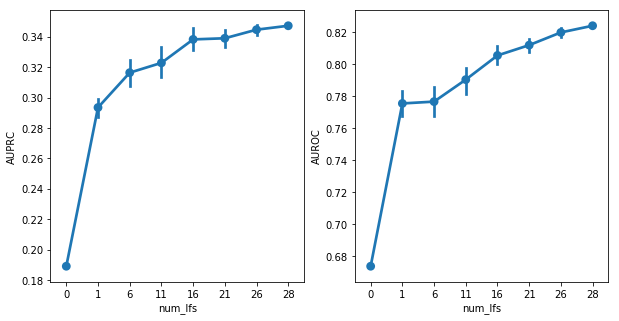

In [27]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUPRC", data=dev_gig_df, ax=axs[0])
sns.pointplot(x="num_lfs", y="AUROC", data=dev_gig_df, ax=axs[1])

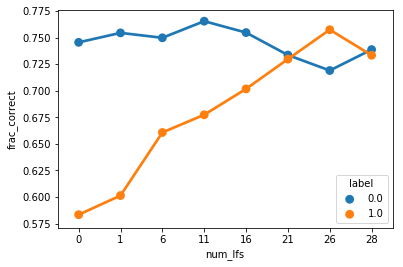

In [28]:
sns.pointplot(x="num_lfs", y="frac_correct", data=dev_gig_marginals_df, hue="label")

## Test Set Performance (AUPRC, AUROC)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


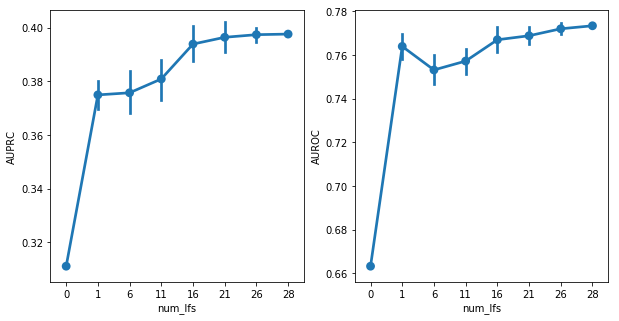

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUPRC", data=test_gig_df, ax=axs[0])
sns.pointplot(x="num_lfs", y="AUROC", data=test_gig_df, ax=axs[1])

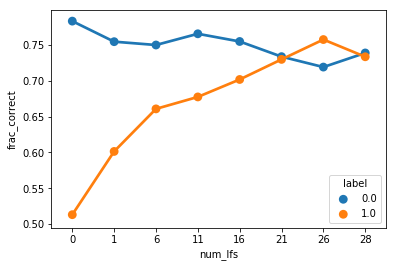

In [30]:
sns.pointplot(x="num_lfs", y="frac_correct", data=test_gig_marginals_df, hue="label")

In [31]:
dev_gig_df.to_csv(
    "data/random_sampling/GiG/results/dev_sampled_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_gig_df.to_csv(
    "data/random_sampling/GiG/results/test_sampled_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [32]:
dev_gig_marginals_df.to_csv(
    "data/random_sampling/GiG/results/dev_sampled_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_gig_marginals_df.to_csv(
    "data/random_sampling/GiG/results/test_sampled_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

# Using Disease Associates Gene Label Functions to Predict Gene Interacts Gene Relations

This section determines how well disease associates gene label functions can predict gene interacts gene relations.

In [33]:
num_of_samples = 50
regularization_grid = pd.np.round(pd.np.linspace(0.01, 5, num=10), 2)

In [34]:
dev_dag_df = pd.DataFrame(dev_baseline)
test_dag_df = pd.DataFrame(test_baseline)
dev_dag_marginals_df = pd.DataFrame(dev_baseline_marginals, columns=["marginals", "label"]).assign(num_lfs=0)
test_dag_marginals_df = pd.DataFrame(test_baseline_marginals, columns=["marginals", "label"]).assign(num_lfs=0)

dag_start = 37
dag_end = 67

range_of_sample_sizes = (
    list(range(1, correct_L[:,dag_start:dag_end].shape[1], 5)) +
    [correct_L[:,dag_start:dag_end].shape[1]]
)

lf_sample_keeper, dev_results_df, test_results_df, dev_marginals_df, test_marginals_df = run_random_additional_lfs(
    range_of_sample_sizes=range_of_sample_sizes, 
    range_of_lf_indicies = list(range(dag_start, dag_end+1)),
    size_of_sample_pool=dag_end-dag_start, 
    num_of_samples=num_of_samples,
    train=correct_L, 
    dev=correct_L_dev,
    dev_labels=candidate_dfs['dev'].curated_gig.values,
    test=correct_L_test,
    test_labels=candidate_dfs['test'].curated_gig.values,
    grid=regularization_grid,
    label_matricies=label_matricies['train'],
    train_marginal_dir='data/random_sampling/DaG/marginals/',
    ds_start=ds_start,
    ds_end=ds_end,
)

dev_dag_df = dev_dag_df.append(dev_results_df, sort=True)
test_dag_df = test_dag_df.append(test_results_df, sort=True)
dev_dag_marginals_df = dev_dag_marginals_df.append(dev_marginals_df, sort=True)
test_dag_marginals_df = test_dag_marginals_df.append(test_marginals_df, sort=True)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [35]:
dev_dag_marginals_df = (
     dev_dag_marginals_df
     .assign(
        frac_correct=(
            dev_dag_marginals_df
            .apply(count_fraction_correct,axis=1)
            .values
        )
    )
    .groupby(["label", "num_lfs"])["frac_correct"]
    .agg(pd.np.mean)
    .reset_index(level=["label", "num_lfs"])
)

In [36]:
test_dag_marginals_df = (
    test_dag_marginals_df
    .assign(
        frac_correct=(
            test_dag_marginals_df
            .apply(count_fraction_correct, axis=1)
            .values
        )
    )
    .groupby(["label", "num_lfs"])["frac_correct"]
    .agg(pd.np.mean)
    .reset_index(level=["label", "num_lfs"])
)

## Dev Set Performance (AUPRC, AUROC)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


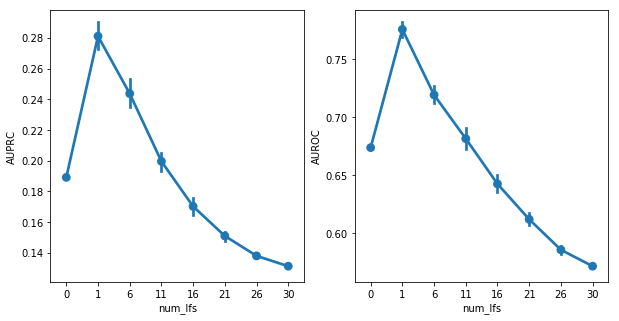

In [37]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUPRC", data=dev_dag_df, ax=axs[0])
sns.pointplot(x="num_lfs", y="AUROC", data=dev_dag_df, ax=axs[1])

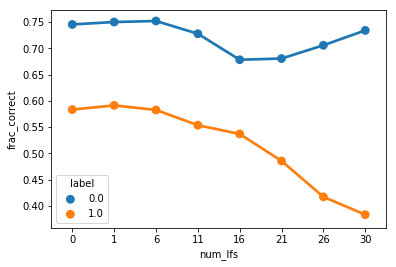

In [38]:
sns.pointplot(x="num_lfs", y="frac_correct", data=dev_dag_marginals_df, hue="label")

## Test Set Performance (AUPRC, AUROC)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


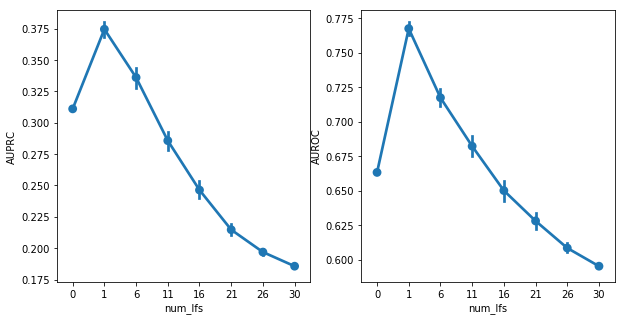

In [39]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUPRC", data=test_dag_df, ax=axs[0])
sns.pointplot(x="num_lfs", y="AUROC", data=test_dag_df, ax=axs[1])

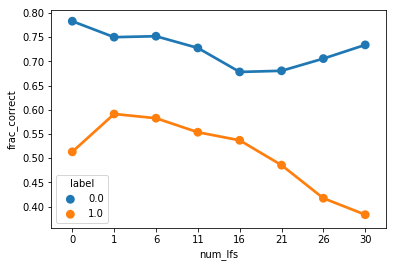

In [40]:
sns.pointplot(x="num_lfs", y="frac_correct", data=test_dag_marginals_df, hue="label")

In [41]:
dev_dag_df.to_csv(
    "data/random_sampling/DaG/results/dev_sampled_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_dag_df.to_csv(
    "data/random_sampling/DaG/results/test_sampled_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [42]:
dev_dag_marginals_df.to_csv(
    "data/random_sampling/DaG/results/dev_sampled_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_dag_marginals_df.to_csv(
    "data/random_sampling/DaG/results/test_sampled_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

# Using Compound Treats Disease Label Functions to Predict Gene Interacts Gene Relations

This section determines how well compound treats disease label functions can predict gene interacts gene relations.

In [43]:
num_of_samples = 50
regularization_grid = pd.np.round(pd.np.linspace(0.01, 5, num=10), 2)

In [ ]:
dev_ctd_df = pd.DataFrame(dev_baseline)
test_ctd_df = pd.DataFrame(test_baseline)
dev_ctd_marginals_df = pd.DataFrame(dev_baseline_marginals, columns=["marginals", "label"]).assign(num_lfs=0)
test_ctd_marginals_df = pd.DataFrame(test_baseline_marginals, columns=["marginals", "label"]).assign(num_lfs=0)

ctd_start = 67
ctd_end = 89

range_of_sample_sizes = (
    list(range(1, correct_L[:,ctd_start:ctd_end].shape[1], 5)) +
    [correct_L[:,ctd_start:ctd_end].shape[1]]
)

lf_sample_keeper, dev_results_df, test_results_df, dev_marginals_df, test_marginals_df = run_random_additional_lfs(
    range_of_sample_sizes=range_of_sample_sizes, 
    range_of_lf_indicies = list(range(ctd_start, ctd_end+1)),
    size_of_sample_pool=ctd_end-ctd_start,
    num_of_samples=num_of_samples,
    train=correct_L, 
    dev=correct_L_dev,
    dev_labels=candidate_dfs['dev'].curated_gig.values,
    test=correct_L_test,
    test_labels=candidate_dfs['test'].curated_gig.values,
    grid=regularization_grid,
    label_matricies=label_matricies['train'],
    train_marginal_dir='data/random_sampling/CtD/marginals/',
    ds_start=ds_start,
    ds_end=ds_end,
)

dev_ctd_df = dev_ctd_df.append(dev_results_df, sort=True)
test_ctd_df = test_ctd_df.append(test_results_df, sort=True)
dev_ctd_marginals_df = dev_ctd_marginals_df.append(dev_marginals_df, sort=True)
test_ctd_marginals_df = test_ctd_marginals_df.append(test_marginals_df, sort=True)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [ ]:
dev_ctd_marginals_df = (
     dev_ctd_marginals_df
     .assign(
        frac_correct=(
            dev_ctd_marginals_df
            .apply(count_fraction_correct,axis=1)
            .values
        )
    )
    .groupby(["label", "num_lfs"])["frac_correct"]
    .agg(pd.np.mean)
    .reset_index(level=["label", "num_lfs"])
 )

In [ ]:
test_ctd_marginals_df = (
    test_ctd_marginals_df
    .assign(
        frac_correct=(
            test_ctd_marginals_df
            .apply(count_fraction_correct, axis=1)
            .values
        )
    )
    .groupby(["label", "num_lfs"])["frac_correct"]
    .agg(pd.np.mean)
    .reset_index(level=["label", "num_lfs"])
)

## Dev Set Performance (AUPRC, AUROC)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUPRC", data=dev_ctd_df, ax=axs[0])
sns.pointplot(x="num_lfs", y="AUROC", data=dev_ctd_df, ax=axs[1])

In [ ]:
sns.pointplot(x="num_lfs", y="frac_correct", data=dev_ctd_marginals_df, hue="label")

## Test Set Performance (AUPRC, AUROC)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUPRC", data=test_ctd_df, ax=axs[0])
sns.pointplot(x="num_lfs", y="AUROC", data=test_ctd_df, ax=axs[1])

In [ ]:
sns.pointplot(x="num_lfs", y="frac_correct", data=test_ctd_marginals_df, hue="label")

In [ ]:
dev_ctd_df.to_csv(
    "data/random_sampling/CtD/results/dev_sampled_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_ctd_df.to_csv(
    "data/random_sampling/CtD/results/test_sampled_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [ ]:
dev_ctd_marginals_df.to_csv(
    "data/random_sampling/CtD/results/dev_sampled_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_ctd_marginals_df.to_csv(
    "data/random_sampling/CtD/results/test_sampled_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

# Using Compound Binds Gene Label Functions to Predict Gene Interacts Gene Relations

This section determines how well compound binds gene label functions can predict gene interacts gene relations.

In [ ]:
num_of_samples = 50
regularization_grid = pd.np.round(pd.np.linspace(0.01, 5, num=10), 2)

In [ ]:
dev_cbg_df = pd.DataFrame(dev_baseline)
test_cbg_df = pd.DataFrame(test_baseline)
dev_cbg_marginals_df = pd.DataFrame(dev_baseline_marginals, columns=["marginals", "label"]).assign(num_lfs=0)
test_cbg_marginals_df = pd.DataFrame(test_baseline_marginals, columns=["marginals", "label"]).assign(num_lfs=0)

cbg_start = 89
cbg_end = 109

range_of_sample_sizes = (
    list(range(1, correct_L[:,cbg_start:cbg_end].shape[1], 5)) +
    [correct_L[:,cbg_start:cbg_end].shape[1]]
)

lf_sample_keeper, dev_results_df, test_results_df, dev_marginals_df, test_marginals_df = run_random_additional_lfs(
    range_of_sample_sizes=range_of_sample_sizes, 
    range_of_lf_indicies = list(range(cbg_start, cbg_end+1)),
    size_of_sample_pool=cbg_end-cbg_start,
    num_of_samples=num_of_samples,
    train=correct_L, 
    dev=correct_L_dev,
    dev_labels=candidate_dfs['dev'].curated_gig.values,
    test=correct_L_test,
    test_labels=candidate_dfs['test'].curated_gig.values,
    grid=regularization_grid,
    label_matricies=label_matricies['train'],
    train_marginal_dir='data/random_sampling/CbG/marginals/',
    ds_start=ds_start,
    ds_end=ds_end,
)

dev_cbg_df = dev_cbg_df.append(dev_results_df, sort=True)
test_cbg_df = test_cbg_df.append(test_results_df, sort=True)
dev_cbg_marginals_df = dev_cbg_marginals_df.append(dev_marginals_df, sort=True)
test_cbg_marginals_df = test_cbg_marginals_df.append(test_marginals_df, sort=True)

In [ ]:
dev_cbg_marginals_df = (
     dev_cbg_marginals_df
     .assign(
        frac_correct=(
            dev_cbg_marginals_df
            .apply(count_fraction_correct,axis=1)
            .values
        )
    )
    .groupby(["label", "num_lfs"])["frac_correct"]
    .agg(pd.np.mean)
    .reset_index(level=["label", "num_lfs"])
)

In [ ]:
test_cbg_marginals_df = (
    test_cbg_marginals_df
    .assign(
        frac_correct=(
            test_cbg_marginals_df
            .apply(count_fraction_correct, axis=1)
            .values
        )
    )
    .groupby(["label", "num_lfs"])["frac_correct"]
    .agg(pd.np.mean)
    .reset_index(level=["label", "num_lfs"])
)

## Dev Set Performance (AUPRC, AUROC)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUPRC", data=dev_cbg_df, ax=axs[0])
sns.pointplot(x="num_lfs", y="AUROC", data=dev_cbg_df, ax=axs[1])

In [ ]:
sns.pointplot(x="num_lfs", y="frac_correct", data=dev_cbg_marginals_df, hue="label")

## Test Set Performance (AUPRC, AUROC)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUPRC", data=test_cbg_df, ax=axs[0])
sns.pointplot(x="num_lfs", y="AUROC", data=test_cbg_df, ax=axs[1])

In [ ]:
sns.pointplot(x="num_lfs", y="frac_correct", data=test_cbg_marginals_df, hue="label")

In [ ]:
dev_cbg_df.to_csv(
    "data/random_sampling/CbG/results/dev_sampled_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_cbg_df.to_csv(
    "data/random_sampling/CbG/results/test_sampled_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [ ]:
dev_cbg_marginals_df.to_csv(
    "data/random_sampling/CbG/results/dev_sampled_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_cbg_marginals_df.to_csv(
    "data/random_sampling/CbG/results/test_sampled_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

# All (DaG, GiG, CbG, CtD) Label Functions to Predict Gene Interacts Gene Relations

This section determines how well all label functions can predict gene interacts gene relations.

In [22]:
num_of_samples = 50
regularization_grid = pd.np.round(pd.np.linspace(0.01, 5, num=5), 2)

In [23]:
all_dev_result_df = pd.DataFrame(dev_baseline)
all_test_result_df = pd.DataFrame(test_baseline)
dev_all_marginals_df = pd.DataFrame(dev_baseline_marginals, columns=["marginals", "label"]).assign(num_lfs=0)
test_all_marginals_df = pd.DataFrame(test_baseline_marginals, columns=["marginals", "label"]).assign(num_lfs=0)

range_of_sample_sizes = (
    list(range(1, correct_L[:,ds_end:].shape[1], 8)) +
    [correct_L[:,ds_end:].shape[1]]
)

lf_sample_keeper, dev_results_df, test_results_df, dev_marginals_df, test_marginals_df = run_random_additional_lfs(
    range_of_sample_sizes=range_of_sample_sizes, 
    range_of_lf_indicies = list(range(ds_end, correct_L.shape[1]+1)),
    size_of_sample_pool=correct_L.shape[1]-ds_end,
    num_of_samples=num_of_samples,
    train=correct_L, 
    dev=correct_L_dev,
    dev_labels=candidate_dfs['dev'].curated_gig.values,
    test=correct_L_test,
    test_labels=candidate_dfs['test'].curated_gig.values,
    grid=regularization_grid,
    label_matricies=label_matricies['train'],
    train_marginal_dir='data/random_sampling/all/marginals/',
    ds_start=ds_start,
    ds_end=ds_end,
)

all_dev_result_df = all_dev_result_df.append(dev_results_df, sort=True)
all_test_result_df = all_test_result_df.append(test_results_df, sort=True)
dev_all_marginals_df = dev_all_marginals_df.append(dev_marginals_df, sort=True)
test_all_marginals_df = test_all_marginals_df.append(test_marginals_df, sort=True)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

In [27]:
dev_all_marginals_df = (
     dev_all_marginals_df
     .assign(
        frac_correct=(
            dev_all_marginals_df
            .apply(count_fraction_correct,axis=1)
            .values
        )
    )
    .groupby(["label", "num_lfs"])["frac_correct"]
    .agg(pd.np.mean)
    .reset_index(level=["label", "num_lfs"])
 )

In [28]:
test_all_marginals_df = (
    test_all_marginals_df
    .assign(
        frac_correct=(
            test_all_marginals_df
            .apply(count_fraction_correct, axis=1)
            .values
        )
    )
    .groupby(["label", "num_lfs"])["frac_correct"]
    .agg(pd.np.mean)
    .reset_index(level=["label", "num_lfs"])
)

## Dev Set Performance (AUPRC, AUROC)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


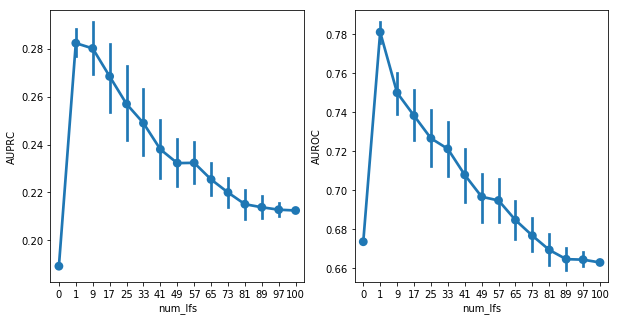

In [29]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUPRC", data=all_dev_result_df, ax=axs[0])
sns.pointplot(x="num_lfs", y="AUROC", data=all_dev_result_df, ax=axs[1])

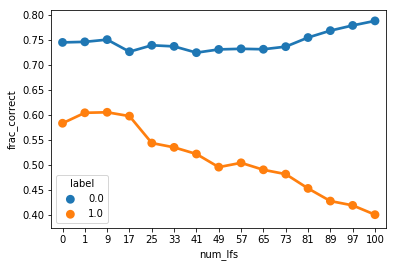

In [30]:
sns.pointplot(x="num_lfs", y="frac_correct", data=dev_all_marginals_df, hue="label")

## Test Set Performance (AUPRC, AUROC)

/home/danich1/anaconda2/envs/snorkeling/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


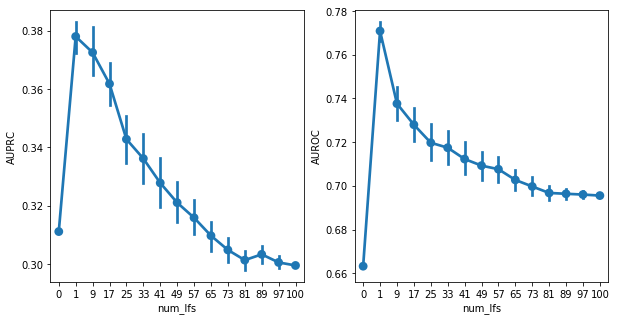

In [31]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
sns.pointplot(x="num_lfs", y="AUPRC", data=all_test_result_df, ax=axs[0])
sns.pointplot(x="num_lfs", y="AUROC", data=all_test_result_df, ax=axs[1])

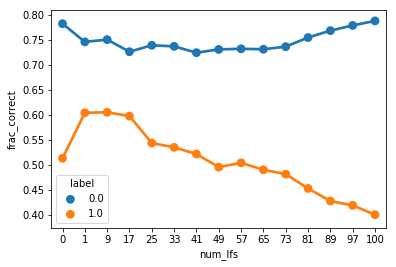

In [32]:
sns.pointplot(x="num_lfs", y="frac_correct", data=test_all_marginals_df, hue="label")

In [33]:
all_dev_result_df.to_csv(
    "data/random_sampling/all/dev_sampled_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

all_test_result_df.to_csv(
    "data/random_sampling/all/test_sampled_performance.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

In [34]:
dev_all_marginals_df.to_csv(
    "data/random_sampling/all/dev_sampled_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)

test_all_marginals_df.to_csv(
    "data/random_sampling/all/test_sampled_marginals.tsv", 
    index=False, sep="\t", float_format="%.5g"
)